By Akinde Kadjo

**Goal:** The goal of this project is to predict whether a patient has Covid or not based on their CT scan. The Dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset?rvi=1).

**More About the Data:** These are publicly available SARS-CoV-2 CT scan (Chest scans: Lung CT)  dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. 

In [1]:
#!pip install opencv-python 
#!pip install rembg
#(skip if already installed)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = 'retina'
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from PIL import Image
from rembg import remove

import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Image Visualization

covid image shape (254, 342, 3)
non covid image shape (326, 382, 4)


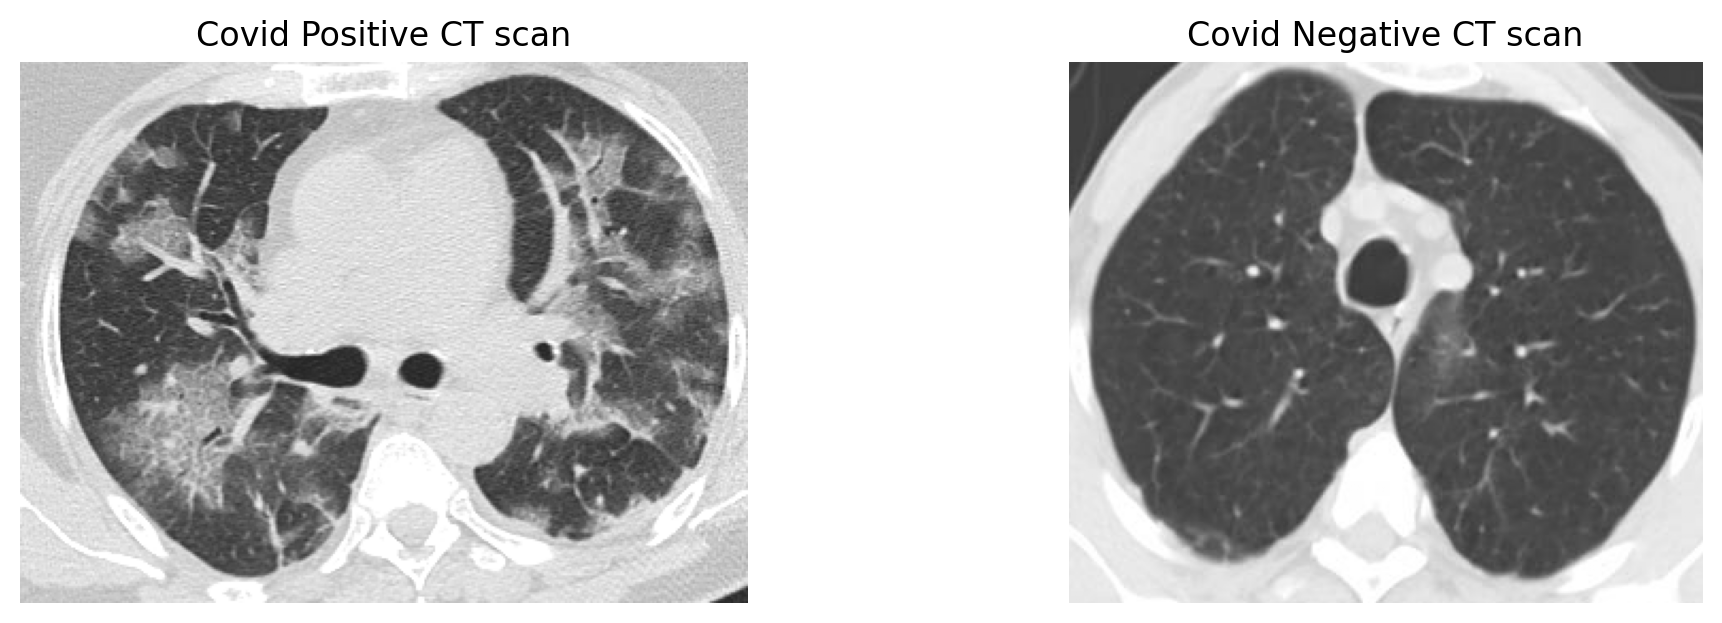

In [3]:
covid_img = plt.imread('COVID/Covid (2).png')#Let's import a covid positive scan
noncovid_img = plt.imread('non-COVID/Non-Covid (5).png')#Let's import a covid negative scan

print(f'covid image shape {covid_img.shape}')
print(f'non covid image shape {noncovid_img.shape}')

fig, ax = plt.subplots(1,2,figsize = (10,3),constrained_layout=True)
ax[0].imshow(covid_img)
ax[0].set_title('Covid Positive CT scan') 
ax[1].imshow(noncovid_img)
ax[1].set_title('Covid Negative CT scan') 
ax[0].axis("off")
ax[1].axis("off")
plt.show()

For simplification, I'll convert all images to grayscale  (so as to have one channel) and resize them all to 500 by 500 pixels.

(500, 500)
(500, 500)


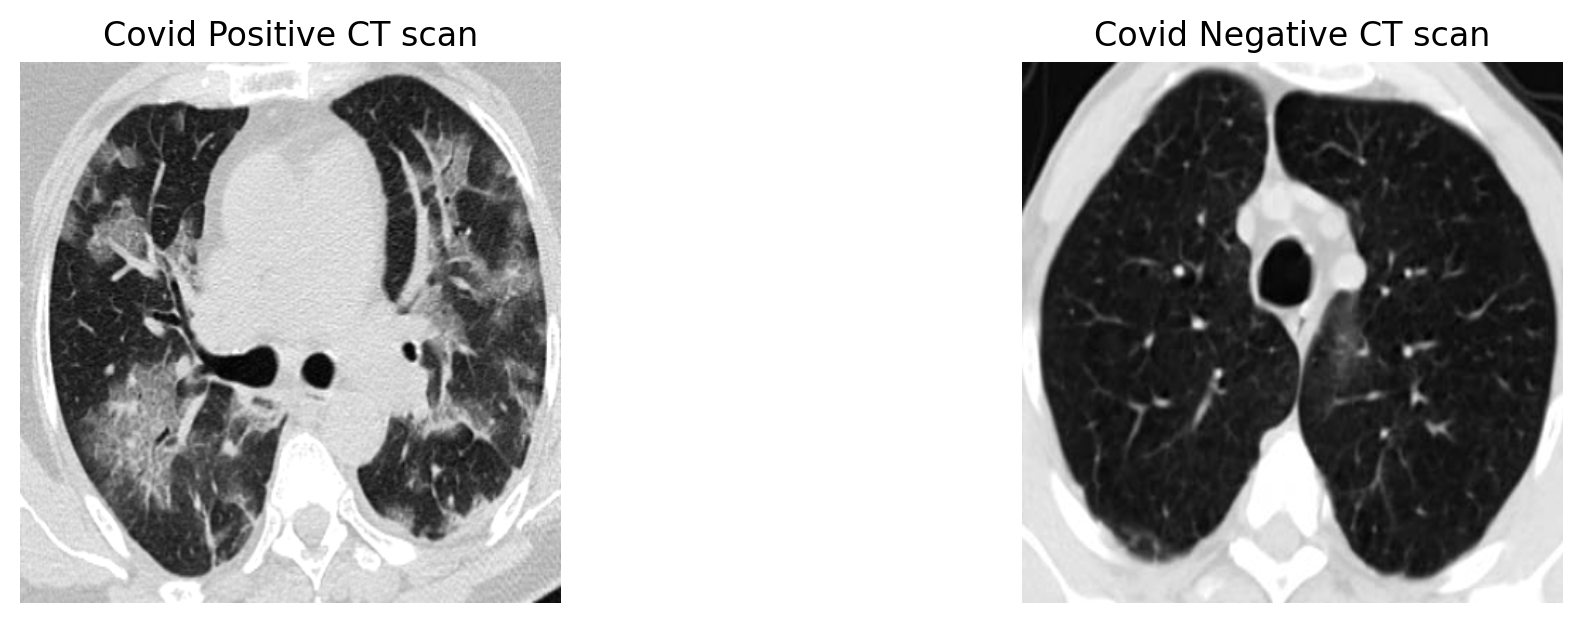

In [4]:
gray_covid = cv2.cvtColor(covid_img, cv2.COLOR_BGR2GRAY)
gray_covid = cv2.resize(gray_covid, (500, 500))
print(gray_covid.shape)
gray_noncovid = cv2.cvtColor(noncovid_img, cv2.COLOR_BGR2GRAY)
gray_noncovid = cv2.resize(gray_noncovid, (500, 500))
print(gray_noncovid.shape)
fig, ax = plt.subplots(1,2,figsize = (10,3),constrained_layout=True)
ax[0].imshow(gray_covid, cmap = 'gray')
ax[0].set_title('Covid Positive CT scan') 
ax[1].imshow(gray_noncovid, cmap = 'gray')
ax[1].set_title('Covid Negative CT scan') 
ax[0].axis("off")
ax[1].axis("off")
plt.show()

At first glance we can see that the covid positive image has white/gray tissues in the lung than the covid negative image.

Text(0.5, 1.0, 'Covid Negative pixel distribution')

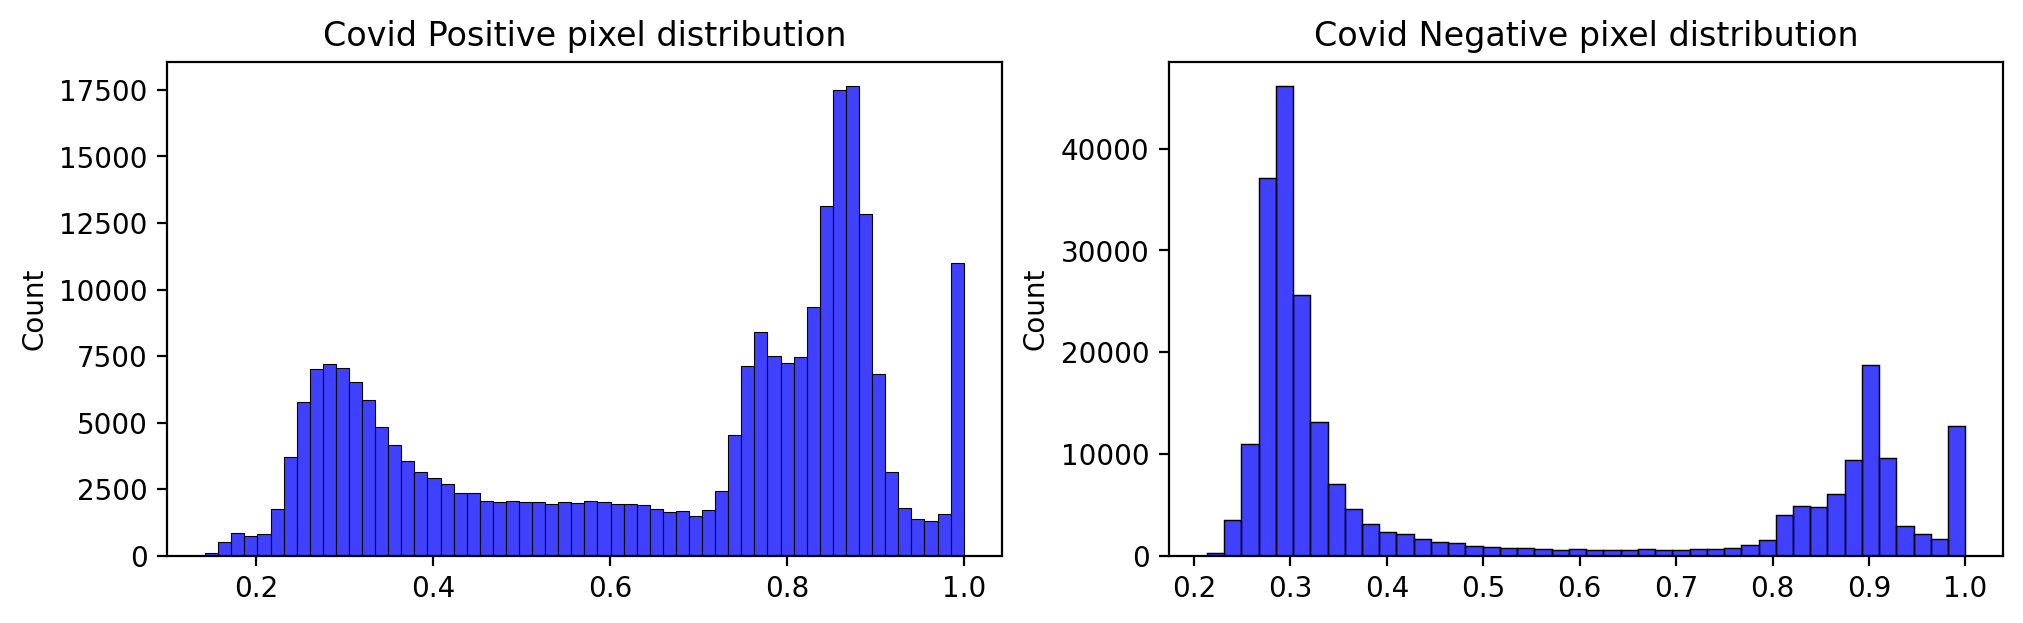

In [5]:
fig, ax = plt.subplots(1,2,figsize = (10,3),constrained_layout=True)
sns.histplot(ax = ax[0],  x=pd.Series(gray_covid.flatten()) ,color='blue')
ax[0].set_title('Covid Positive pixel distribution')
sns.histplot(ax = ax[1],  x=pd.Series(gray_noncovid.flatten()) ,color='blue')
ax[1].set_title('Covid Negative pixel distribution')

This indeed confirms that the covid positive image, has more pixels leaning towards white/gray

## Removing background

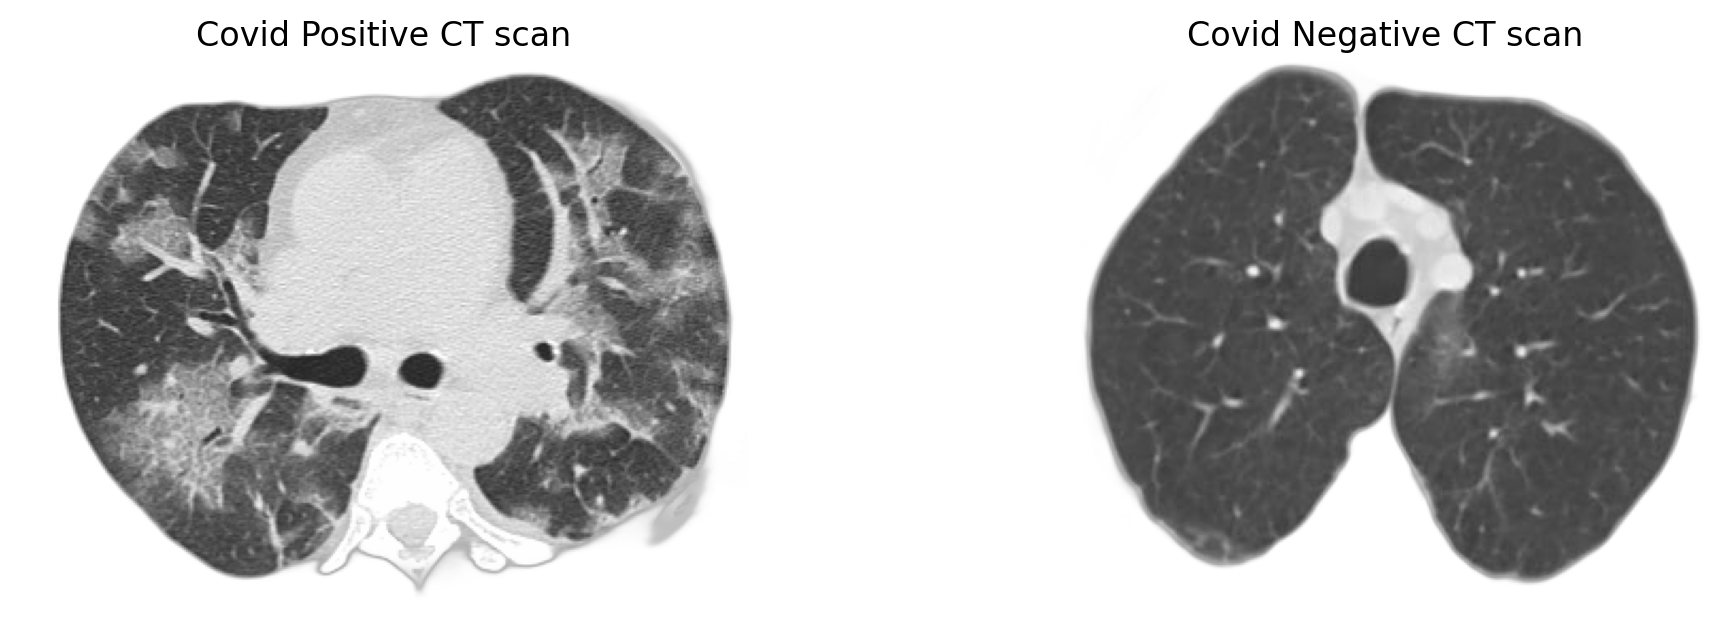

In [6]:
covid_img = Image.open('COVID/Covid (2).png')
noncovid_img = Image.open('non-COVID/Non-Covid (5).png')
pos = remove(covid_img)
neg = remove(noncovid_img)
fig, ax = plt.subplots(1,2,figsize = (10,3),constrained_layout=True)
ax[0].imshow(pos, cmap = 'gray')
ax[0].set_title('Covid Positive CT scan') 
ax[1].imshow(neg, cmap = 'gray')
ax[1].set_title('Covid Negative CT scan') 
ax[0].axis("off")
ax[1].axis("off")
plt.show()

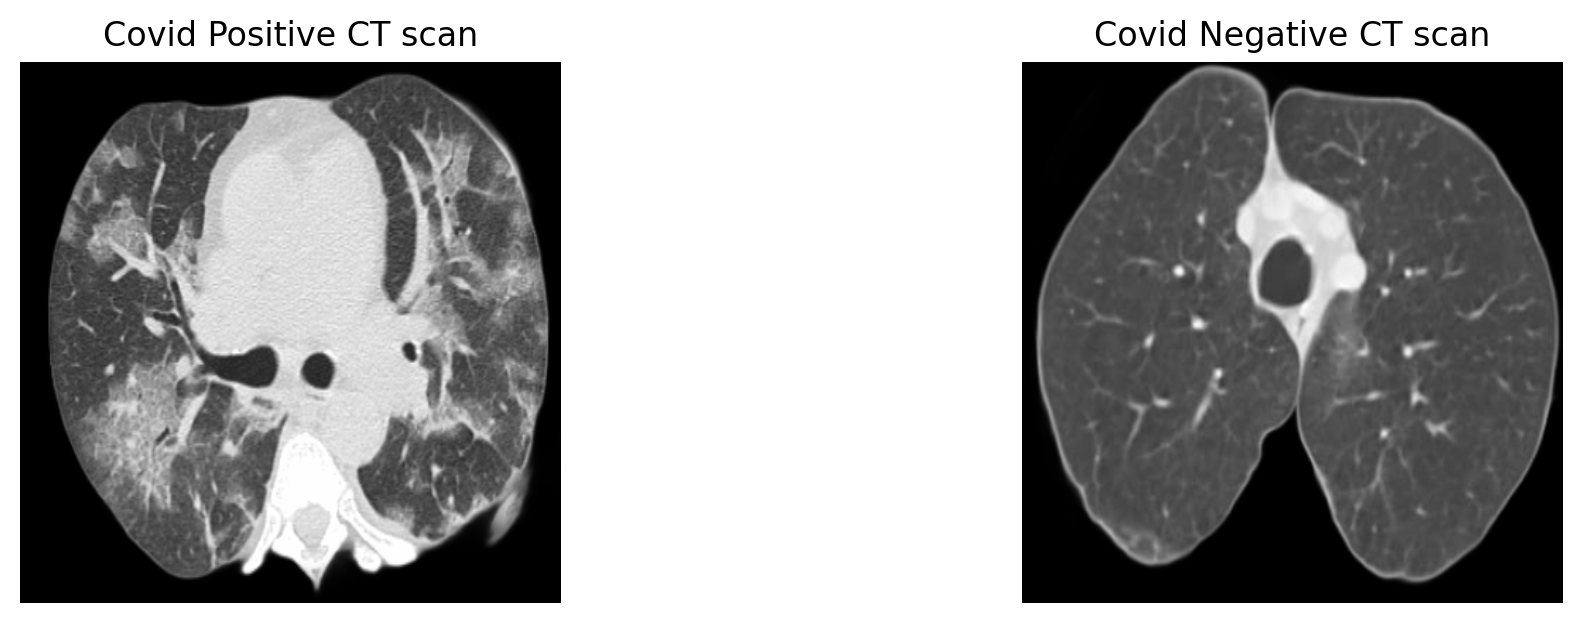

In [7]:
gray_pos = cv2.cvtColor(np.array(pos), cv2.COLOR_BGR2GRAY)
gray_pos = cv2.resize(gray_pos, (500, 500))
gray_neg = cv2.cvtColor(np.array(neg), cv2.COLOR_BGR2GRAY)
gray_neg = cv2.resize(gray_neg, (500, 500))

fig, ax = plt.subplots(1,2,figsize = (10,3),constrained_layout=True)
ax[0].imshow(gray_pos, cmap = 'gray')
ax[0].set_title('Covid Positive CT scan') 
ax[1].imshow(gray_neg, cmap = 'gray')
ax[1].set_title('Covid Negative CT scan') 
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# Functions

In order to keep a clean notebook, I'm storing all of the functions that I've created in this section. These functions pertain to data extraction, data cleaning, plots, prediction models and regression outputs.

In [2]:
def imagestoarray(directory):
    # empty list to store the images
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = cv2.imread(os.path.join(directory, filename))
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(gray_image, (500, 500))
            images.append(resized_image)
    images_array = np.array(images, dtype=np.float32)

    return images_array

In [3]:
#same but including brackground removal
def bg_imagestoarray(directory):
    # empty list to store the images
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = Image.open(os.path.join(directory, filename))
            image =  remove(image)
            gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(gray_image, (500, 500))
            images.append(resized_image)
    images_array = np.array(images, dtype=np.float32)

    return images_array

# Data Extraction

In [10]:
covid_array = imagestoarray('COVID')
covid_array = (covid_array/255).reshape(((len(covid_array)), 500, 500, 1))
print(f'covid array shape {covid_array.shape}')
noncovid_array = imagestoarray('non-COVID')
noncovid_array = (noncovid_array/255).reshape(((len(noncovid_array)), 500, 500, 1))
print(f'noncovid array shape {noncovid_array.shape}')

covid array shape (1252, 500, 500, 1)
noncovid array shape (1229, 500, 500, 1)


In [11]:
X = np.concatenate((covid_array,noncovid_array))
print(f'X shape: {X.shape}')
y = np.concatenate((np.ones(len(covid_array)), np.zeros(len(noncovid_array)) ))
print(f'y shape: {y.shape}')

X shape: (2481, 500, 500, 1)
y shape: (2481,)


# CNN with Data as is

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.10)

In [13]:
# Define the CNN model
model = keras.Sequential(
    [
        keras.Input(shape=(500, 500, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [14]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=15, validation_split=0.1)

Epoch 1/15
16/16 [==============================] - 638s 37s/step - loss: 4.4442 - accuracy: 0.5055 - val_loss: 0.6917 - val_accuracy: 0.5670
Epoch 2/15
16/16 [==============================] - 494s 30s/step - loss: 0.6950 - accuracy: 0.5468 - val_loss: 0.6940 - val_accuracy: 0.4420
Epoch 3/15
16/16 [==============================] - 512s 32s/step - loss: 0.6757 - accuracy: 0.6091 - val_loss: 0.6412 - val_accuracy: 0.6830
Epoch 4/15
16/16 [==============================] - 443s 27s/step - loss: 0.6113 - accuracy: 0.6748 - val_loss: 0.5147 - val_accuracy: 0.7634
Epoch 5/15
16/16 [==============================] - 485s 31s/step - loss: 0.4665 - accuracy: 0.7849 - val_loss: 0.4012 - val_accuracy: 0.8438
Epoch 6/15
16/16 [==============================] - 580s 36s/step - loss: 0.3332 - accuracy: 0.8606 - val_loss: 0.3648 - val_accuracy: 0.8750
Epoch 7/15
16/16 [==============================] - 573s 35s/step - loss: 0.3362 - accuracy: 0.8660 - val_loss: 0.3697 - val_accuracy: 0.8661
Epoch 

In [16]:
# let's evaluate the model on the test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'The test accuracy is {round(test_accuracy*100,2)} %')

8/8 [==============================] - 7s 887ms/step - loss: 0.2910 - accuracy: 0.8876
The test accuracy is 88.76 %


# CNN with Data without Image Background

In [4]:
covid_array = bg_imagestoarray('COVID')
covid_array = (covid_array/255).reshape(((len(covid_array)), 500, 500, 1))
print(f'covid array shape {covid_array.shape}')
noncovid_array = bg_imagestoarray('non-COVID')
noncovid_array = (noncovid_array/255).reshape(((len(noncovid_array)), 500, 500, 1))
print(f'noncovid array shape {noncovid_array.shape}')

X = np.concatenate((covid_array,noncovid_array))
print(f'X shape: {X.shape}')
y = np.concatenate((np.ones(len(covid_array)), np.zeros(len(noncovid_array)) ))
print(f'y shape: {y.shape}')

covid array shape (1252, 500, 500, 1)
noncovid array shape (1229, 500, 500, 1)
X shape: (2481, 500, 500, 1)
y shape: (2481,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.10)

In [6]:
# Define the CNN model
model = keras.Sequential(
    [
        keras.Input(shape=(500, 500, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [7]:
# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=15, validation_split=0.1)

Epoch 1/15
16/16 [==============================] - 451s 27s/step - loss: 2.0941 - accuracy: 0.5090 - val_loss: 0.6904 - val_accuracy: 0.4375
Epoch 2/15
16/16 [==============================] - 452s 29s/step - loss: 0.6883 - accuracy: 0.5354 - val_loss: 0.6852 - val_accuracy: 0.5357
Epoch 3/15
16/16 [==============================] - 533s 33s/step - loss: 0.6410 - accuracy: 0.6529 - val_loss: 0.5595 - val_accuracy: 0.7321
Epoch 4/15
16/16 [==============================] - 559s 35s/step - loss: 0.5364 - accuracy: 0.7301 - val_loss: 0.4785 - val_accuracy: 0.7857
Epoch 5/15
16/16 [==============================] - 541s 34s/step - loss: 0.4372 - accuracy: 0.8157 - val_loss: 0.4340 - val_accuracy: 0.8170
Epoch 6/15
16/16 [==============================] - 546s 34s/step - loss: 0.3436 - accuracy: 0.8586 - val_loss: 0.3965 - val_accuracy: 0.8348
Epoch 7/15
16/16 [==============================] - 530s 33s/step - loss: 0.2566 - accuracy: 0.9059 - val_loss: 0.3745 - val_accuracy: 0.8393
Epoch 

In [8]:
# let's evaluate the model on the test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'The test accuracy is {round(test_accuracy*100,2)} %')

8/8 [==============================] - 4s 537ms/step - loss: 0.4973 - accuracy: 0.8554
The test accuracy is 85.54 %


# Conclusion

Overall 89% accuracy was obtained. This score can definitely be improved with some additional tuning. Removing the background from the images didn't help much.